In [199]:
import random

def maj(x, y, z):
    return (x & y) ^ (y & z) ^ (z & x)

def ch(x, y, z):
    return (x & y) ^ ((x ^ 1) & z)

def KSG128(state):
    return state[12] ^ state[154] ^ maj(state[235], state[61], state[193])

def FBK128(state, ca, cb):
    ks = KSG128(state)
    f  = (state[0] ^ 
            (state[107] ^ 1) ^ 
            maj(state[244], state[23], state[160])^
            ch(state[230], state[111], state[66]) ^ 
            (ca & state[196]) ^
            (cb & ks)) 
    return f, ks

def StateUpdate128(state, m, ca, cb, debug=False):
    state[289] ^= state[235] ^ state[230]
    state[230] ^= state[196] ^ state[193]
    state[193] ^= state[160] ^ state[154]
    state[154] ^= state[111] ^ state[107]
    state[107] ^= state[ 66] ^ state[ 61]
    state[ 61] ^= state[ 23] ^ state[  0]
    f, ks = FBK128(state, ca, cb)
    state.append(f ^ m)
    state.pop(0)    
    mx = ks ^ m
    if debug:
        print(m, end='')
        print(ca, end='')
        print(cb, end='>')
        print(mx, end=':')
    return state, mx

def StateInit(key, iv):
    msg = ([key[i] for i in range(128)] + 
           [iv [i] for i in range(128)] + 
           [key[(i) & 0x7f] for i in range(1792-256)])
    msg[256] ^= 1
    #print("StateInit message")
    '''for j,k in enumerate(msg):
        print(k, end="")
        if not (j+1) % 128:
            print()
    print()'''
    state = [0 for i in range(293)]
    states = []
    ca = 1
    cb = 1        
    for i in range(1792):
        m = msg.pop(0)
        #print(int(i/8), ':', i%8, end=' ')
        #print('stateUpdate', m, ca, cb)
        state, mx = StateUpdate128(state, m, ca, cb)
        states.append(list(state))
    return state, states

def AssociatedData(state, ad):
    states = []    
    ca = 1
    cb = 1        
    for i in ad:
        state, mx = StateUpdate128(state, i, ca, cb)
        states.append(list(state))
        
    print("AssociatedData:")
    for j,k in enumerate(state):
        print(k, " ", end="")
        if not (j+1) % 16:
            print()
    print()        
    state, mx = StateUpdate128(state, 1, ca, cb)
    states.append(list(state))
    for i in range(127):
        state, mx = StateUpdate128(state, 0, ca, cb)
        states.append(list(state))
    ca = 0       
    for i in range(128):
        state, mx = StateUpdate128(state, 0, ca, cb)
        states.append(list(state))
    return state, states


def Encrypt(state, pt):
    states = []
    ct = []
    ca = 1
    cb = 0
    for i in pt:
        state, mx = StateUpdate128(state, i, ca, cb)#, debug=True)
        ct.append(mx)
        states.append(list(state))
       
    state, mx = StateUpdate128(state, 1, ca, cb)
    states.append(list(state))
    for i in range(127):
        state, mx = StateUpdate128(state, 0, ca, cb)
        states.append(list(state))
    ca = 0       
    for i in range(128):
        state, mx = StateUpdate128(state, 0, ca, cb)
        states.append(list(state))
        
    return state, states, ct

def tag_generation(state):
    states = []
    mac = []
    for i in range(768):
        ca = 1
        cb = 1
        m = 0
        state, mx = StateUpdate128(state, m, ca, cb)
        states.append(list(state))
        if i >= (768 - 128):
            mac.append(mx)
    return state, states, mac

In [206]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def draw2DArray(array2D, aspect='auto'):    
    plt.figure(figsize=(60,60))
    imgplot = plt.imshow(array2D, interpolation="nearest", aspect=aspect)
    imgplot.set_cmap('binary')
    print(imgplot.get_size())

    return imgplot

key       : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
iv        : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


StateInit:
1  0  1  0  1  0  0  0  1  1  0  0  1  0  0  1  
0  1  1  0  1  0  0  1  1  1  1  1  0  1  0  0  
1  0  1  0  1  1  1  0  1  0  1  0  0  0  0  1  
0  1  0  1  0  1  1  0  1  0  0  1  1  1  0  0  
1  0  1  0  1  0  1  1  0  0  1  1  1  0  0  1  
1  0  0  0  0  0  0  1  1  0  0  1  1  1  0  0  
1  1  1  0  1  0  0  1  1  1  0  0  0  0  0  0  
1  0  1  1  0  0  0  1  1  0  1  1  1  1  1  0  
1  0  1  1  0  0  1  0  1  0  0  1  0  0  1  0  
0  0  0  0  0  0  0  0  0  1  1  0  0  1  0  1  
1  1  1  1  1  0  0  0  1  0  1  0  0  0  1  0  
1  1  0  1  0  0  1  1  1  0  1  1  0  0  1  1  
0  1  0  0  0  1  1  1  1  0  0  0  1  0  0  0  
0  0  1  0  0  0  1  0  0  0  0  0  1  1  0  0  
0  1  0  0  1  1  1  1  1  1  1  0  1  0  1  0  
1  0  0  1  1  1  0  1  0  1  0  1  0  0  0  1  
0  0  1  1  0  0  1  0  0  1  0  1  1  1  0  1  
1  1  0  1  0  0  1  0  0  1  1 

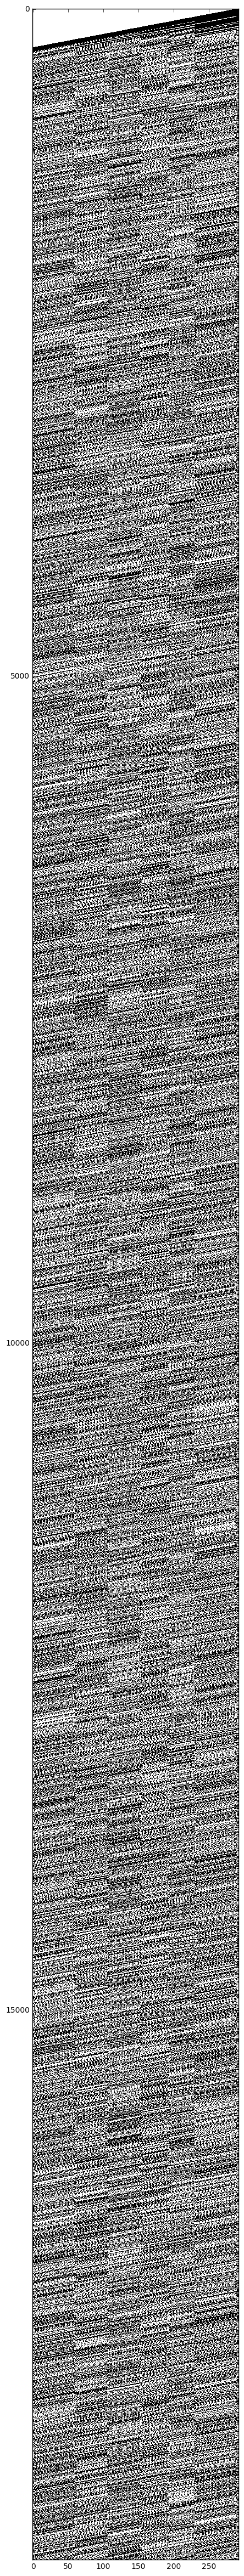

In [207]:
def byte2bin(byteArray):    
    return [(i >> j) & 0x01 for i in byteArray for j in range(8)]

def bit2byte(bitData):
    byteData = []
    for i in range(int(len(bitData)/8)):
        ct1 = 0
        for j in bitData[i*8:(1+i)*8]:
            ct1 = (ct1 >> 1) ^ (j << 7)
        byteData.append(ct1)
    return byteData

key = [0 for i in range(16)]
key[0] = 1;
iv = [0 for i in range(16)]
plaintext  = [i%256 for i in range(1003)]
ad         = [i%7   for i in range(1003)]

print('key       :', key)
print('iv        :', iv)

AllStates = []
state, states = StateInit(byte2bin(key), byte2bin(iv))
AllStates += states
print("\n\nStateInit:")
for j,k in enumerate(state):
    print(k, " ", end="")
    if not (j+1) % 16:
        print()
print()
state, states = AssociatedData(state, byte2bin(ad))
AllStates += states
print("\n\nAssociatedData:")
for j,k in enumerate(state):
    print(k, " ", end="")
    if not (j+1) % 16:
        print()
print()
state, states, ct = Encrypt(state, byte2bin(plaintext))
AllStates += states
print("\n\npt:")
for j,k in enumerate(state):
    print(k, " ", end="")
    if not (j+1) % 16:
        print()
print()

ciphertext = bit2byte(ct)

print("\n\ciphertext: ");
for j,k in enumerate(ciphertext):
    print(hex(k), " ", end="")
    if not (j+1) % 16:
        print()
print()    

state, states, mac = tag_generation(state)
AllStates += states
mactext = bit2byte(mac)

print("\n\nmac: ");
for j,k in enumerate(mactext):
    print(hex(k), " ", end="")
    if not (j+1) % 16:
        print()
print()    

print("\n\nfinalisation:")
for j,k in enumerate(state):
    print(k, " ", end="")
    if not (j+1) % 16:
        print()
print()

draw2DArray(AllStates, aspect=292.0/1536)